In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.25,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_025_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 11:55 - loss: 0.1541 - STD: 1.3954e-04 - MAE: 0.3800

 12/632 [..............................] - ETA: 2s - loss: 0.0416 - STD: 2.1405e-04 - MAE: 0.1582   

 23/632 [>.............................] - ETA: 2s - loss: 0.0300 - STD: 1.7822e-04 - MAE: 0.1286

 35/632 [>.............................] - ETA: 2s - loss: 0.0245 - STD: 1.5779e-04 - MAE: 0.1095

 47/632 [=>............................] - ETA: 2s - loss: 0.0215 - STD: 1.5642e-04 - MAE: 0.1001

 59/632 [=>............................] - ETA: 2s - loss: 0.0196 - STD: 1.6660e-04 - MAE: 0.0931

 70/632 [==>...........................] - ETA: 2s - loss: 0.0186 - STD: 1.9037e-04 - MAE: 0.0898

 81/632 [==>...........................] - ETA: 2s - loss: 0.0178 - STD: 2.3211e-04 - MAE: 0.0870

 92/632 [===>..........................] - ETA: 2s - loss: 0.0172 - STD: 3.0694e-04 - MAE: 0.0849

105/632 [===>..........................] - ETA: 2s - loss: 0.0166 - STD: 4.8502e-04 - MAE: 0.0829

118/632 [====>.........................] - ETA: 2s - loss: 0.0160 - STD: 9.0740e-04 - MAE: 0.0812

130/632 [=====>........................] - ETA: 2s - loss: 0.0156 - STD: 0.0019 - MAE: 0.0797    

142/632 [=====>........................] - ETA: 2s - loss: 0.0150 - STD: 0.0040 - MAE: 0.0778

152/632 [======>.......................] - ETA: 2s - loss: 0.0144 - STD: 0.0071 - MAE: 0.0758

162/632 [======>.......................] - ETA: 2s - loss: 0.0138 - STD: 0.0113 - MAE: 0.0736

174/632 [=======>......................] - ETA: 2s - loss: 0.0131 - STD: 0.0167 - MAE: 0.0711

187/632 [=======>......................] - ETA: 2s - loss: 0.0124 - STD: 0.0222 - MAE: 0.0686

199/632 [========>.....................] - ETA: 1s - loss: 0.0118 - STD: 0.0265 - MAE: 0.0665

211/632 [=========>....................] - ETA: 1s - loss: 0.0113 - STD: 0.0305 - MAE: 0.0647

223/632 [=========>....................] - ETA: 1s - loss: 0.0108 - STD: 0.0342 - MAE: 0.0630

235/632 [==========>...................] - ETA: 1s - loss: 0.0104 - STD: 0.0374 - MAE: 0.0614

247/632 [==========>...................] - ETA: 1s - loss: 0.0100 - STD: 0.0406 - MAE: 0.0600

259/632 [===========>..................] - ETA: 1s - loss: 0.0096 - STD: 0.0433 - MAE: 0.0586

271/632 [===========>..................] - ETA: 1s - loss: 0.0093 - STD: 0.0458 - MAE: 0.0575

282/632 [============>.................] - ETA: 1s - loss: 0.0090 - STD: 0.0480 - MAE: 0.0565

292/632 [============>.................] - ETA: 1s - loss: 0.0088 - STD: 0.0498 - MAE: 0.0556

302/632 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 0.0515 - MAE: 0.0548

312/632 [=============>................] - ETA: 1s - loss: 0.0084 - STD: 0.0532 - MAE: 0.0540

322/632 [==============>...............] - ETA: 1s - loss: 0.0082 - STD: 0.0547 - MAE: 0.0533

332/632 [==============>...............] - ETA: 1s - loss: 0.0080 - STD: 0.0562 - MAE: 0.0525

343/632 [===============>..............] - ETA: 1s - loss: 0.0078 - STD: 0.0577 - MAE: 0.0518

354/632 [===============>..............] - ETA: 1s - loss: 0.0076 - STD: 0.0591 - MAE: 0.0511

364/632 [================>.............] - ETA: 1s - loss: 0.0074 - STD: 0.0604 - MAE: 0.0505

375/632 [================>.............] - ETA: 1s - loss: 0.0073 - STD: 0.0617 - MAE: 0.0499

386/632 [=================>............] - ETA: 1s - loss: 0.0071 - STD: 0.0628 - MAE: 0.0493

397/632 [=================>............] - ETA: 1s - loss: 0.0070 - STD: 0.0639 - MAE: 0.0487

408/632 [==================>...........] - ETA: 1s - loss: 0.0069 - STD: 0.0651 - MAE: 0.0482

420/632 [==================>...........] - ETA: 1s - loss: 0.0067 - STD: 0.0661 - MAE: 0.0477

432/632 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.0671 - MAE: 0.0471

444/632 [====================>.........] - ETA: 1s - loss: 0.0064 - STD: 0.0681 - MAE: 0.0467

456/632 [====================>.........] - ETA: 1s - loss: 0.0063 - STD: 0.0691 - MAE: 0.0462

468/632 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0700 - MAE: 0.0457

480/632 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0709 - MAE: 0.0453

492/632 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0716 - MAE: 0.0449

504/632 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0725 - MAE: 0.0445

516/632 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0732 - MAE: 0.0441

528/632 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0739 - MAE: 0.0438

540/632 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0746 - MAE: 0.0434

552/632 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0752 - MAE: 0.0430

564/632 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0759 - MAE: 0.0427

576/632 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0765 - MAE: 0.0424

588/632 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0770 - MAE: 0.0421

600/632 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0775 - MAE: 0.0418

612/632 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0415

624/632 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0413

632/632 [==============================] - 5s 7ms/step - loss: 0.0050 - STD: 0.0789 - MAE: 0.0411 - val_loss: 0.0016 - val_STD: 0.0776 - val_MAE: 0.0286


Epoch 2/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

 13/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266 

 24/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

 34/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0269

 44/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0269

 54/632 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

 64/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0270

 74/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0269

 84/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0269

 94/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0269

104/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0270

114/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0269

125/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0269

135/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0270

145/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0271

155/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0271

167/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0271

179/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0271

191/632 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0271

203/632 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0271

215/632 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0271

227/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

239/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

251/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

263/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0271

276/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

289/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

301/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

313/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

325/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

337/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

349/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

361/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

373/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

385/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

397/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

409/632 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

422/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

434/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

446/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

458/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

471/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

483/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

496/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

509/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

521/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

532/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

544/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

556/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

568/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

580/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

592/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

604/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

616/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

629/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

632/632 [==============================] - 3s 5ms/step - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270 - val_loss: 0.0023 - val_STD: 0.0838 - val_MAE: 0.0341


Epoch 3/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0271

 13/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0273 

 25/632 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

 37/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0268

 49/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0268

 59/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0267

 70/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0266

 82/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

 92/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0264

104/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0264

116/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

127/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0263

138/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0262

150/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0263

162/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0263

175/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

185/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

196/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

206/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

218/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

230/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0263

242/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0263

254/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

266/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0263

278/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0263

289/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

300/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

312/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

324/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

334/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

344/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

353/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

364/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

375/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

387/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

398/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

410/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0263

423/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

436/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

447/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

458/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

469/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

481/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

493/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

506/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

517/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

529/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

541/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

552/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

563/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

574/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

586/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

598/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

610/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

621/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

631/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

632/632 [==============================] - 3s 5ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263 - val_loss: 0.0018 - val_STD: 0.0836 - val_MAE: 0.0299


Epoch 4/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0251

 12/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0257 

 24/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0259

 36/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

 47/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

 58/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

 68/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

 78/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

 88/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

 98/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

111/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0261

124/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

136/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

146/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

156/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

166/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

177/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

188/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

198/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0261

208/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0261

218/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

228/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

237/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

247/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

257/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

268/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

278/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

288/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

298/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

308/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

318/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

328/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

337/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

347/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

357/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

367/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

379/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

391/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

402/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

413/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

423/632 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

433/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

444/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

456/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

468/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

480/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

492/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

502/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

512/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

522/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

532/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

542/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

552/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

562/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

572/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

582/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

593/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

605/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

617/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

629/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258 - val_loss: 0.0016 - val_STD: 0.0850 - val_MAE: 0.0280


Epoch 5/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0012 - STD: 0.1022 - MAE: 0.0242

 10/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1080 - MAE: 0.0250 

 21/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1080 - MAE: 0.0250

 31/632 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1079 - MAE: 0.0254

 41/632 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0255

 51/632 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1077 - MAE: 0.0256

 61/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0256

 72/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0258

 82/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0257

 92/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0257

102/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0256

113/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

123/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

134/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

145/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

156/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

167/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

178/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

188/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

199/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

211/632 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

222/632 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

232/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

243/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

254/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

265/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

275/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

285/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

295/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

305/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

315/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

325/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

335/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

346/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

358/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

369/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

380/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

391/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

402/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

412/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

422/632 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

433/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

444/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

454/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

464/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

475/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

487/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

499/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

512/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

525/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

538/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

550/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

560/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

570/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

580/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

591/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

601/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

611/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

623/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256 - val_loss: 0.0016 - val_STD: 0.0827 - val_MAE: 0.0279


Epoch 6/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0011 - STD: 0.0998 - MAE: 0.0235

 13/632 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248 

 24/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

 35/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

 45/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

 55/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

 65/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

 76/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

 87/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

 99/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

110/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

120/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

130/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

142/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

154/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

166/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

176/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0248

187/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0249

199/632 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0248

212/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

224/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

236/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

248/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

260/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

272/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

284/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

296/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

308/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

320/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

332/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

344/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

356/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

368/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

380/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

392/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

404/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

416/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

428/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

440/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

453/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

466/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

478/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

490/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

502/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

514/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

526/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

538/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

551/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

563/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

575/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

587/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

599/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

610/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

622/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248 - val_loss: 0.0017 - val_STD: 0.0871 - val_MAE: 0.0278


Epoch 7/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0011 - STD: 0.1030 - MAE: 0.0234

 12/632 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0251 

 22/632 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

 33/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

 43/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0248

 55/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0247

 67/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

 80/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0248

 92/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

105/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

117/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

129/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

141/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

152/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

164/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

174/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

184/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

194/632 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

204/632 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

214/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

224/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

236/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

248/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

260/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

272/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

282/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

293/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

304/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

315/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

328/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

340/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

351/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

362/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

373/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

384/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

395/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

405/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

414/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

424/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

435/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

447/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

458/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

470/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

480/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

491/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

503/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

514/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

526/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

538/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

549/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

560/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

572/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

584/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

596/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0246

608/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

620/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

632/632 [==============================] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

632/632 [==============================] - 3s 5ms/step - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245 - val_loss: 0.0021 - val_STD: 0.0874 - val_MAE: 0.0318


Epoch 8/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0012 - STD: 0.1052 - MAE: 0.0240

 10/632 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1080 - MAE: 0.0242 

 19/632 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0240

 29/632 [>.............................] - ETA: 3s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0239

 39/632 [>.............................] - ETA: 3s - loss: 0.0012 - STD: 0.1077 - MAE: 0.0240

 49/632 [=>............................] - ETA: 3s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0239

 60/632 [=>............................] - ETA: 3s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0240

 70/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0242

 80/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0242

 92/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0241

103/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0241

113/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0241

123/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0241

133/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

143/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

153/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

163/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

173/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

183/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

193/632 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0242

205/632 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

217/632 [=========>....................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

229/632 [=========>....................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

241/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

253/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0243

263/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0243

275/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0243

287/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0243

299/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0243

311/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0243

323/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0242

335/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0243

347/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

360/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

372/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

384/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

396/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

408/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

420/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

432/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

444/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

456/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

468/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

480/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

492/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

502/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

514/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

526/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

538/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

550/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

561/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

572/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

583/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

594/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

606/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

618/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

630/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

632/632 [==============================] - 3s 5ms/step - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241 - val_loss: 0.0017 - val_STD: 0.0859 - val_MAE: 0.0279


Epoch 9/10000


  1/632 [..............................] - ETA: 9s - loss: 0.0010 - STD: 0.1092 - MAE: 0.0220

 13/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1093 - MAE: 0.0240

 25/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0239

 37/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1077 - MAE: 0.0237

 47/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0238

 58/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

 70/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

 82/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

 94/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0237

106/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0237

117/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0237

127/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

137/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0236

147/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

158/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

168/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

178/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

188/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

199/632 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

211/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

223/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0238

235/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0239

247/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0239

259/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0239

271/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0238

282/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

294/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

306/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

317/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

329/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

341/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

353/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

365/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

377/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

389/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

401/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

413/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0237

424/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

434/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

443/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

454/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

466/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

478/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

491/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

504/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

516/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

526/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

538/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

550/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

562/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

573/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

584/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

596/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

608/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

620/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

632/632 [==============================] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

632/632 [==============================] - 3s 5ms/step - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237 - val_loss: 0.0014 - val_STD: 0.0828 - val_MAE: 0.0269


Epoch 10/10000


  1/632 [..............................] - ETA: 9s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0251

 12/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0256

 23/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0253

 35/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1052 - MAE: 0.0248

 47/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0244

 59/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0244

 71/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1060 - MAE: 0.0242

 82/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0241

 93/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0240

104/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0240

114/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0239

124/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0239

134/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0238

144/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0237

154/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0237

165/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0237

177/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0236

189/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0236

201/632 [========>.....................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0235

213/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

225/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0236

237/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0235

249/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0236

261/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0235

273/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0235

285/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0235

297/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0235

309/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0235

321/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0234

333/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0235

345/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0235

357/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0235

369/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0235

381/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0235

393/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0235

406/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0235

419/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0235

431/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0235

443/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0235

455/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0235

468/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0235

480/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0235

492/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0235

504/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0235

516/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0235

528/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0235

540/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

552/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

564/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

576/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

588/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

600/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

612/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

624/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234 - val_loss: 0.0019 - val_STD: 0.0868 - val_MAE: 0.0291


Epoch 11/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0011 - STD: 0.1157 - MAE: 0.0232

 11/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1050 - MAE: 0.0228 

 23/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0230

 35/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1061 - MAE: 0.0234

 47/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0236

 60/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1063 - MAE: 0.0235

 72/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0234

 84/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1065 - MAE: 0.0233

 96/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0234

109/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0234

122/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0234

135/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0233

148/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1065 - MAE: 0.0233

161/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1063 - MAE: 0.0233

174/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1065 - MAE: 0.0232

186/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0232

199/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0232

212/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0233

225/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0233

237/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0233

249/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0233

261/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0232

273/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0232

285/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0232

297/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0232

309/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0232

321/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0232

333/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0232

345/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0232

357/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0232

369/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

381/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

393/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

405/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

417/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

430/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

443/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

455/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

466/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

476/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

486/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

496/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

507/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

518/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

528/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

538/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

548/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

560/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

572/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

584/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

597/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

609/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

621/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

632/632 [==============================] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231 - val_loss: 0.0021 - val_STD: 0.0875 - val_MAE: 0.0305


Epoch 12/10000


  1/632 [..............................] - ETA: 9s - loss: 0.0012 - STD: 0.1080 - MAE: 0.0239

 12/632 [..............................] - ETA: 2s - loss: 0.0010 - STD: 0.1060 - MAE: 0.0225

 23/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1069 - MAE: 0.0225

 33/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0226

 44/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1072 - MAE: 0.0224

 54/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1072 - MAE: 0.0224

 64/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0226

 75/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0227

 87/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0227

 99/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0226

111/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0226

123/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0227

135/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0227

147/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

159/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

171/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

183/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0227

194/632 [========>.....................] - ETA: 2s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0227

206/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0227

218/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0227

230/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0227

241/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0227

251/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0228

261/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

271/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

281/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

292/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

303/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0228

315/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

327/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

339/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

351/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0228

361/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0228

371/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

382/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0227

392/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0228

402/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

412/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

422/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

432/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

443/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

454/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

464/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

474/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

485/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0227

495/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0227

506/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0227

516/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0227

526/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0227

537/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0228

549/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0228

560/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

571/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

581/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

590/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

600/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

610/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

621/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

631/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227 - val_loss: 0.0022 - val_STD: 0.0888 - val_MAE: 0.0302


Epoch 13/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0010 - STD: 0.1164 - MAE: 0.0226

 11/632 [..............................] - ETA: 3s - loss: 0.0010 - STD: 0.1109 - MAE: 0.0229 

 22/632 [>.............................] - ETA: 3s - loss: 0.0010 - STD: 0.1100 - MAE: 0.0226

 32/632 [>.............................] - ETA: 3s - loss: 0.0010 - STD: 0.1096 - MAE: 0.0225

 42/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1088 - MAE: 0.0225

 52/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1087 - MAE: 0.0226

 62/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1089 - MAE: 0.0225

 73/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1085 - MAE: 0.0226

 83/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1085 - MAE: 0.0226

 93/632 [===>..........................] - ETA: 2s - loss: 0.0010 - STD: 0.1082 - MAE: 0.0226

103/632 [===>..........................] - ETA: 2s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0226

113/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0226

123/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

133/632 [=====>........................] - ETA: 2s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0225

143/632 [=====>........................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

153/632 [======>.......................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

164/632 [======>.......................] - ETA: 2s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0225

175/632 [=======>......................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

186/632 [=======>......................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

196/632 [========>.....................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

207/632 [========>.....................] - ETA: 2s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0225

217/632 [=========>....................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

227/632 [=========>....................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

237/632 [==========>...................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

248/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

258/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

268/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

279/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0225

290/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

300/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

310/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

320/632 [==============>...............] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0225

330/632 [==============>...............] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

340/632 [===============>..............] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

350/632 [===============>..............] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

362/632 [================>.............] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

374/632 [================>.............] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

386/632 [=================>............] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

398/632 [=================>............] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

410/632 [==================>...........] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

421/632 [==================>...........] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

433/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

445/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

457/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

469/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

481/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

493/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

505/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

517/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

529/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

541/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

554/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

567/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

580/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

593/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

605/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

617/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

629/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

632/632 [==============================] - 3s 5ms/step - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224 - val_loss: 0.0020 - val_STD: 0.0867 - val_MAE: 0.0297


Epoch 14/10000


  1/632 [..............................] - ETA: 9s - loss: 0.0011 - STD: 0.1151 - MAE: 0.0235

 13/632 [..............................] - ETA: 2s - loss: 0.0011 - STD: 0.1082 - MAE: 0.0236

 24/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0229

 36/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0227

 47/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0225

 59/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0225

 69/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0224

 80/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0225

 90/632 [===>..........................] - ETA: 2s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

101/632 [===>..........................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

113/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

125/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

136/632 [=====>........................] - ETA: 2s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0222

146/632 [=====>........................] - ETA: 2s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0223

156/632 [======>.......................] - ETA: 2s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

167/632 [======>.......................] - ETA: 2s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0224

177/632 [=======>......................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

188/632 [=======>......................] - ETA: 2s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

200/632 [========>.....................] - ETA: 2s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

212/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0223

224/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

236/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

247/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0223

257/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

269/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

281/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0223

293/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0223

306/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0223

318/632 [==============>...............] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0223

330/632 [==============>...............] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0223

342/632 [===============>..............] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0223

354/632 [===============>..............] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

367/632 [================>.............] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0223

380/632 [=================>............] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

390/632 [=================>............] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

401/632 [==================>...........] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

413/632 [==================>...........] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

425/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

435/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

445/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

455/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

465/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

475/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

487/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

499/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

509/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

519/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

529/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

540/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

552/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

563/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

575/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

588/632 [==========================>...] - ETA: 0s - loss: 9.9885e-04 - STD: 0.1078 - MAE: 0.0222

600/632 [===========================>..] - ETA: 0s - loss: 9.9800e-04 - STD: 0.1078 - MAE: 0.0222

613/632 [============================>.] - ETA: 0s - loss: 9.9748e-04 - STD: 0.1078 - MAE: 0.0222

625/632 [============================>.] - ETA: 0s - loss: 9.9786e-04 - STD: 0.1078 - MAE: 0.0222

632/632 [==============================] - 3s 5ms/step - loss: 9.9704e-04 - STD: 0.1078 - MAE: 0.0222 - val_loss: 0.0021 - val_STD: 0.0873 - val_MAE: 0.0305


Epoch 15/10000


  1/632 [..............................] - ETA: 12s - loss: 8.0284e-04 - STD: 0.1123 - MAE: 0.0203

 11/632 [..............................] - ETA: 3s - loss: 9.2659e-04 - STD: 0.1081 - MAE: 0.0216 

 23/632 [>.............................] - ETA: 2s - loss: 9.5501e-04 - STD: 0.1091 - MAE: 0.0219

 36/632 [>.............................] - ETA: 2s - loss: 9.7035e-04 - STD: 0.1087 - MAE: 0.0220

 49/632 [=>............................] - ETA: 2s - loss: 9.8044e-04 - STD: 0.1090 - MAE: 0.0221

 60/632 [=>............................] - ETA: 2s - loss: 9.8278e-04 - STD: 0.1086 - MAE: 0.0222

 71/632 [==>...........................] - ETA: 2s - loss: 9.8882e-04 - STD: 0.1085 - MAE: 0.0222

 83/632 [==>...........................] - ETA: 2s - loss: 9.8683e-04 - STD: 0.1080 - MAE: 0.0222

 95/632 [===>..........................] - ETA: 2s - loss: 9.8883e-04 - STD: 0.1079 - MAE: 0.0222

107/632 [====>.........................] - ETA: 2s - loss: 9.9303e-04 - STD: 0.1080 - MAE: 0.0222

119/632 [====>.........................] - ETA: 2s - loss: 9.9159e-04 - STD: 0.1078 - MAE: 0.0222

130/632 [=====>........................] - ETA: 2s - loss: 9.9459e-04 - STD: 0.1076 - MAE: 0.0222

142/632 [=====>........................] - ETA: 2s - loss: 9.9538e-04 - STD: 0.1076 - MAE: 0.0222

154/632 [======>.......................] - ETA: 2s - loss: 9.9285e-04 - STD: 0.1076 - MAE: 0.0222

166/632 [======>.......................] - ETA: 2s - loss: 9.9203e-04 - STD: 0.1078 - MAE: 0.0222

178/632 [=======>......................] - ETA: 2s - loss: 9.8900e-04 - STD: 0.1078 - MAE: 0.0222

190/632 [========>.....................] - ETA: 1s - loss: 9.9058e-04 - STD: 0.1079 - MAE: 0.0222

202/632 [========>.....................] - ETA: 1s - loss: 9.9900e-04 - STD: 0.1079 - MAE: 0.0223

214/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0223    

226/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0223

238/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0223

250/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0223

262/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0223

274/632 [============>.................] - ETA: 1s - loss: 9.9820e-04 - STD: 0.1079 - MAE: 0.0222

286/632 [============>.................] - ETA: 1s - loss: 9.9749e-04 - STD: 0.1078 - MAE: 0.0222

298/632 [=============>................] - ETA: 1s - loss: 9.9701e-04 - STD: 0.1078 - MAE: 0.0222

310/632 [=============>................] - ETA: 1s - loss: 9.9513e-04 - STD: 0.1079 - MAE: 0.0222

320/632 [==============>...............] - ETA: 1s - loss: 9.9358e-04 - STD: 0.1079 - MAE: 0.0222

330/632 [==============>...............] - ETA: 1s - loss: 9.9256e-04 - STD: 0.1078 - MAE: 0.0222

340/632 [===============>..............] - ETA: 1s - loss: 9.9184e-04 - STD: 0.1078 - MAE: 0.0222

351/632 [===============>..............] - ETA: 1s - loss: 9.9083e-04 - STD: 0.1077 - MAE: 0.0221

361/632 [================>.............] - ETA: 1s - loss: 9.9109e-04 - STD: 0.1077 - MAE: 0.0221

371/632 [================>.............] - ETA: 1s - loss: 9.9049e-04 - STD: 0.1077 - MAE: 0.0221

381/632 [=================>............] - ETA: 1s - loss: 9.9211e-04 - STD: 0.1078 - MAE: 0.0221

391/632 [=================>............] - ETA: 1s - loss: 9.9191e-04 - STD: 0.1078 - MAE: 0.0222

401/632 [==================>...........] - ETA: 1s - loss: 9.9222e-04 - STD: 0.1077 - MAE: 0.0222

411/632 [==================>...........] - ETA: 1s - loss: 9.9205e-04 - STD: 0.1076 - MAE: 0.0221

421/632 [==================>...........] - ETA: 0s - loss: 9.9221e-04 - STD: 0.1077 - MAE: 0.0222

431/632 [===================>..........] - ETA: 0s - loss: 9.9427e-04 - STD: 0.1077 - MAE: 0.0222

441/632 [===================>..........] - ETA: 0s - loss: 9.9422e-04 - STD: 0.1077 - MAE: 0.0222

450/632 [====================>.........] - ETA: 0s - loss: 9.9345e-04 - STD: 0.1076 - MAE: 0.0222

460/632 [====================>.........] - ETA: 0s - loss: 9.9194e-04 - STD: 0.1076 - MAE: 0.0221

470/632 [=====================>........] - ETA: 0s - loss: 9.9199e-04 - STD: 0.1076 - MAE: 0.0221

481/632 [=====================>........] - ETA: 0s - loss: 9.9016e-04 - STD: 0.1076 - MAE: 0.0221

493/632 [======================>.......] - ETA: 0s - loss: 9.9087e-04 - STD: 0.1076 - MAE: 0.0221

505/632 [======================>.......] - ETA: 0s - loss: 9.8961e-04 - STD: 0.1077 - MAE: 0.0221

516/632 [=======================>......] - ETA: 0s - loss: 9.8831e-04 - STD: 0.1077 - MAE: 0.0221

528/632 [========================>.....] - ETA: 0s - loss: 9.8803e-04 - STD: 0.1077 - MAE: 0.0221

540/632 [========================>.....] - ETA: 0s - loss: 9.8707e-04 - STD: 0.1077 - MAE: 0.0221

552/632 [=========================>....] - ETA: 0s - loss: 9.8767e-04 - STD: 0.1077 - MAE: 0.0221

564/632 [=========================>....] - ETA: 0s - loss: 9.8840e-04 - STD: 0.1077 - MAE: 0.0221

576/632 [==========================>...] - ETA: 0s - loss: 9.8786e-04 - STD: 0.1077 - MAE: 0.0221

588/632 [==========================>...] - ETA: 0s - loss: 9.8678e-04 - STD: 0.1077 - MAE: 0.0221

600/632 [===========================>..] - ETA: 0s - loss: 9.8611e-04 - STD: 0.1078 - MAE: 0.0221

612/632 [============================>.] - ETA: 0s - loss: 9.8524e-04 - STD: 0.1078 - MAE: 0.0221

624/632 [============================>.] - ETA: 0s - loss: 9.8501e-04 - STD: 0.1079 - MAE: 0.0221

632/632 [==============================] - 3s 5ms/step - loss: 9.8533e-04 - STD: 0.1079 - MAE: 0.0221 - val_loss: 0.0016 - val_STD: 0.0845 - val_MAE: 0.0275


Epoch 16/10000


  1/632 [..............................] - ETA: 14s - loss: 9.9038e-04 - STD: 0.0922 - MAE: 0.0218

 11/632 [..............................] - ETA: 3s - loss: 9.4566e-04 - STD: 0.1045 - MAE: 0.0217 

 22/632 [>.............................] - ETA: 2s - loss: 9.3026e-04 - STD: 0.1071 - MAE: 0.0216

 33/632 [>.............................] - ETA: 2s - loss: 9.4001e-04 - STD: 0.1078 - MAE: 0.0217

 44/632 [=>............................] - ETA: 2s - loss: 9.3824e-04 - STD: 0.1075 - MAE: 0.0217

 56/632 [=>............................] - ETA: 2s - loss: 9.4136e-04 - STD: 0.1075 - MAE: 0.0217

 68/632 [==>...........................] - ETA: 2s - loss: 9.4372e-04 - STD: 0.1075 - MAE: 0.0217

 80/632 [==>...........................] - ETA: 2s - loss: 9.4515e-04 - STD: 0.1073 - MAE: 0.0218

 92/632 [===>..........................] - ETA: 2s - loss: 9.5225e-04 - STD: 0.1075 - MAE: 0.0218

104/632 [===>..........................] - ETA: 2s - loss: 9.5357e-04 - STD: 0.1075 - MAE: 0.0218

116/632 [====>.........................] - ETA: 2s - loss: 9.5635e-04 - STD: 0.1077 - MAE: 0.0219

128/632 [=====>........................] - ETA: 2s - loss: 9.5441e-04 - STD: 0.1077 - MAE: 0.0218

140/632 [=====>........................] - ETA: 2s - loss: 9.5327e-04 - STD: 0.1077 - MAE: 0.0218

152/632 [======>.......................] - ETA: 2s - loss: 9.5276e-04 - STD: 0.1077 - MAE: 0.0218

164/632 [======>.......................] - ETA: 2s - loss: 9.5525e-04 - STD: 0.1076 - MAE: 0.0219

176/632 [=======>......................] - ETA: 2s - loss: 9.5601e-04 - STD: 0.1078 - MAE: 0.0219

188/632 [=======>......................] - ETA: 1s - loss: 9.6409e-04 - STD: 0.1078 - MAE: 0.0219

200/632 [========>.....................] - ETA: 1s - loss: 9.6547e-04 - STD: 0.1078 - MAE: 0.0220

212/632 [=========>....................] - ETA: 1s - loss: 9.6364e-04 - STD: 0.1079 - MAE: 0.0219

224/632 [=========>....................] - ETA: 1s - loss: 9.6342e-04 - STD: 0.1079 - MAE: 0.0219

237/632 [==========>...................] - ETA: 1s - loss: 9.6427e-04 - STD: 0.1079 - MAE: 0.0219

250/632 [==========>...................] - ETA: 1s - loss: 9.6431e-04 - STD: 0.1081 - MAE: 0.0219

262/632 [===========>..................] - ETA: 1s - loss: 9.6910e-04 - STD: 0.1081 - MAE: 0.0220

274/632 [============>.................] - ETA: 1s - loss: 9.6938e-04 - STD: 0.1081 - MAE: 0.0220

286/632 [============>.................] - ETA: 1s - loss: 9.7532e-04 - STD: 0.1081 - MAE: 0.0221

298/632 [=============>................] - ETA: 1s - loss: 9.7547e-04 - STD: 0.1081 - MAE: 0.0221

310/632 [=============>................] - ETA: 1s - loss: 9.7609e-04 - STD: 0.1080 - MAE: 0.0221

322/632 [==============>...............] - ETA: 1s - loss: 9.7651e-04 - STD: 0.1080 - MAE: 0.0221

334/632 [==============>...............] - ETA: 1s - loss: 9.7715e-04 - STD: 0.1081 - MAE: 0.0221

346/632 [===============>..............] - ETA: 1s - loss: 9.7542e-04 - STD: 0.1080 - MAE: 0.0220

358/632 [===============>..............] - ETA: 1s - loss: 9.7217e-04 - STD: 0.1080 - MAE: 0.0220

370/632 [================>.............] - ETA: 1s - loss: 9.7066e-04 - STD: 0.1080 - MAE: 0.0220

382/632 [=================>............] - ETA: 1s - loss: 9.7018e-04 - STD: 0.1080 - MAE: 0.0220

394/632 [=================>............] - ETA: 1s - loss: 9.6994e-04 - STD: 0.1080 - MAE: 0.0220

406/632 [==================>...........] - ETA: 0s - loss: 9.6924e-04 - STD: 0.1079 - MAE: 0.0220

416/632 [==================>...........] - ETA: 0s - loss: 9.6758e-04 - STD: 0.1079 - MAE: 0.0219

426/632 [===================>..........] - ETA: 0s - loss: 9.6642e-04 - STD: 0.1079 - MAE: 0.0219

436/632 [===================>..........] - ETA: 0s - loss: 9.6587e-04 - STD: 0.1080 - MAE: 0.0219

446/632 [====================>.........] - ETA: 0s - loss: 9.6416e-04 - STD: 0.1080 - MAE: 0.0219

457/632 [====================>.........] - ETA: 0s - loss: 9.6274e-04 - STD: 0.1080 - MAE: 0.0219

468/632 [=====================>........] - ETA: 0s - loss: 9.6160e-04 - STD: 0.1080 - MAE: 0.0219

479/632 [=====================>........] - ETA: 0s - loss: 9.5953e-04 - STD: 0.1080 - MAE: 0.0219

489/632 [======================>.......] - ETA: 0s - loss: 9.5887e-04 - STD: 0.1080 - MAE: 0.0218

501/632 [======================>.......] - ETA: 0s - loss: 9.5878e-04 - STD: 0.1080 - MAE: 0.0218

512/632 [=======================>......] - ETA: 0s - loss: 9.5806e-04 - STD: 0.1080 - MAE: 0.0218

522/632 [=======================>......] - ETA: 0s - loss: 9.5736e-04 - STD: 0.1080 - MAE: 0.0218

533/632 [========================>.....] - ETA: 0s - loss: 9.5704e-04 - STD: 0.1080 - MAE: 0.0218

544/632 [========================>.....] - ETA: 0s - loss: 9.5669e-04 - STD: 0.1081 - MAE: 0.0218

556/632 [=========================>....] - ETA: 0s - loss: 9.5684e-04 - STD: 0.1081 - MAE: 0.0218

568/632 [=========================>....] - ETA: 0s - loss: 9.5769e-04 - STD: 0.1081 - MAE: 0.0218

580/632 [==========================>...] - ETA: 0s - loss: 9.5700e-04 - STD: 0.1082 - MAE: 0.0218

591/632 [===========================>..] - ETA: 0s - loss: 9.5791e-04 - STD: 0.1081 - MAE: 0.0218

601/632 [===========================>..] - ETA: 0s - loss: 9.5989e-04 - STD: 0.1081 - MAE: 0.0218

612/632 [============================>.] - ETA: 0s - loss: 9.6061e-04 - STD: 0.1081 - MAE: 0.0219

623/632 [============================>.] - ETA: 0s - loss: 9.5984e-04 - STD: 0.1081 - MAE: 0.0218

632/632 [==============================] - 3s 5ms/step - loss: 9.6080e-04 - STD: 0.1080 - MAE: 0.0219 - val_loss: 0.0018 - val_STD: 0.0863 - val_MAE: 0.0280


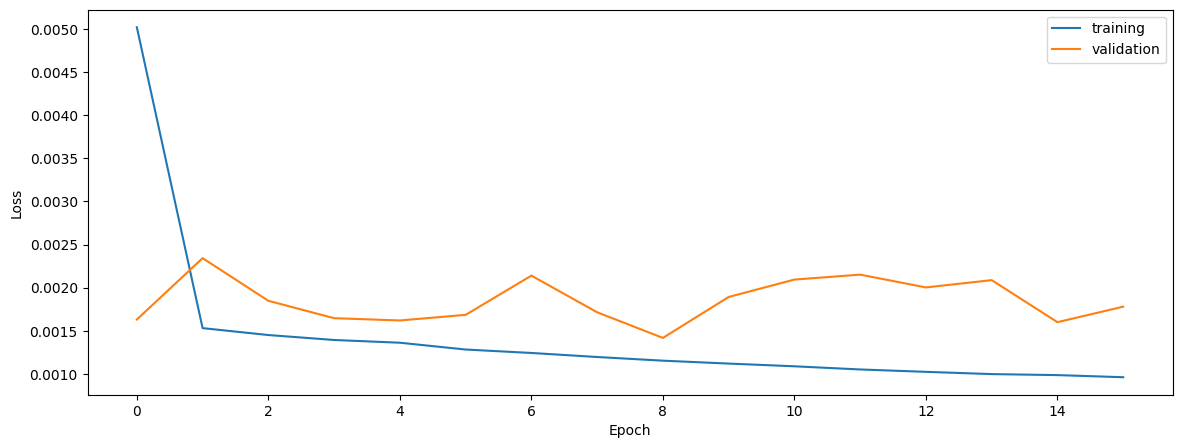

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9564928968852916
0.9585205384783058
0.9454775056943475


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9545974273441984
0.9544363310554091
0.9494291827720783


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9598294063714544
0.9551627292621769
0.9598788428158099


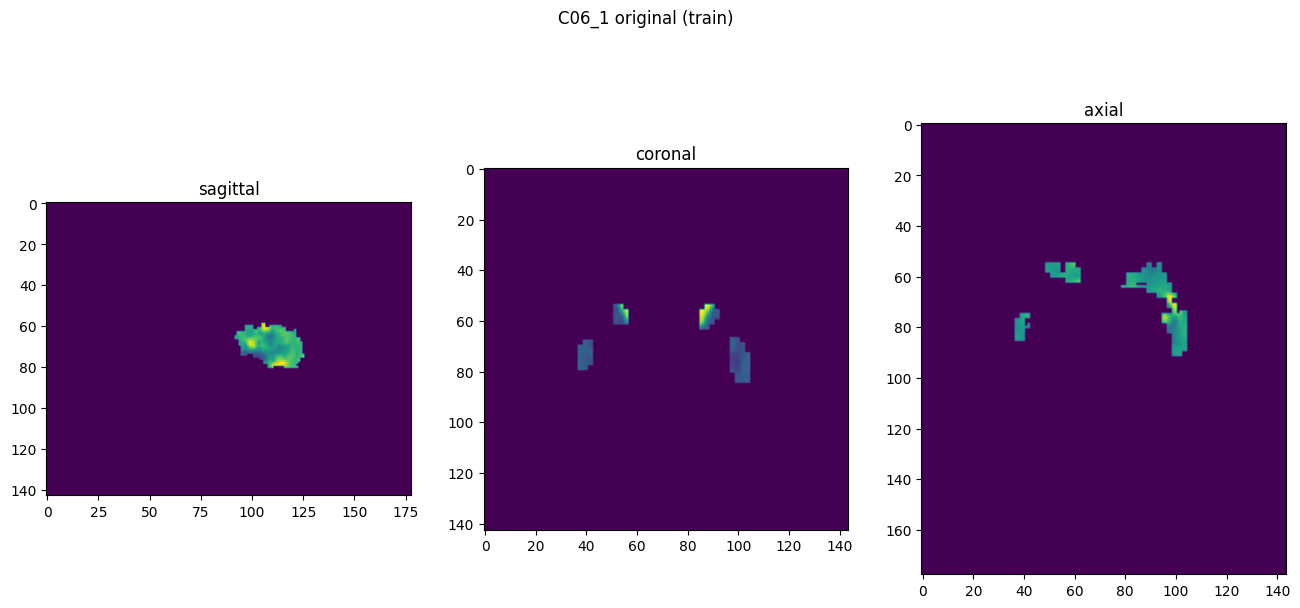

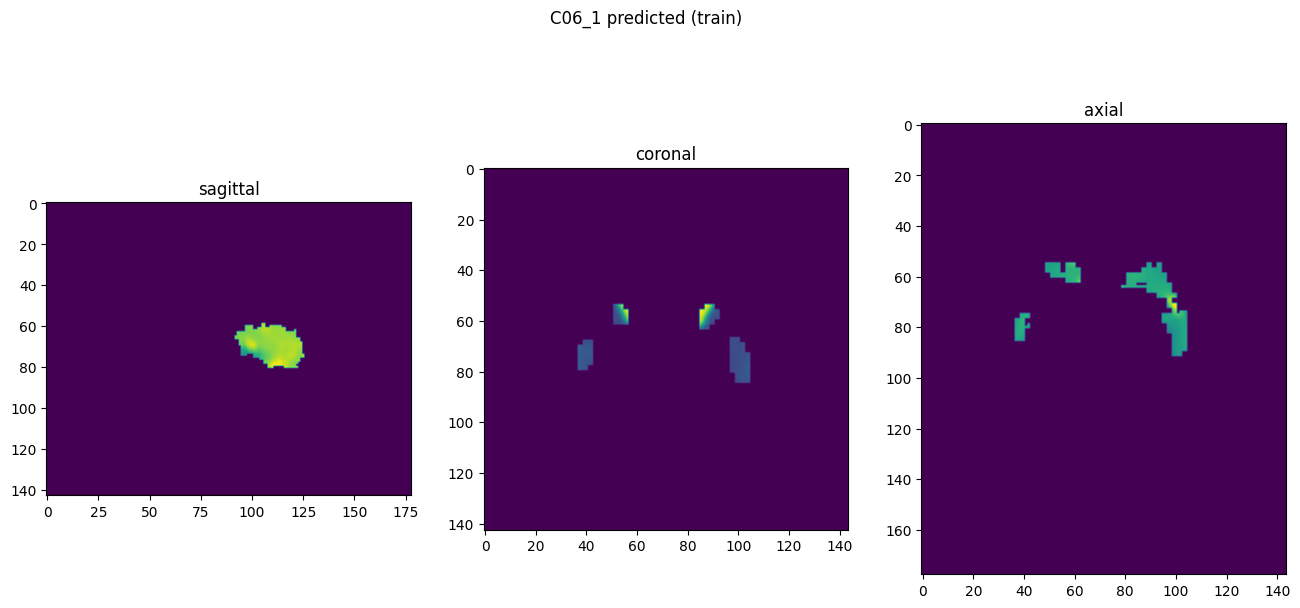

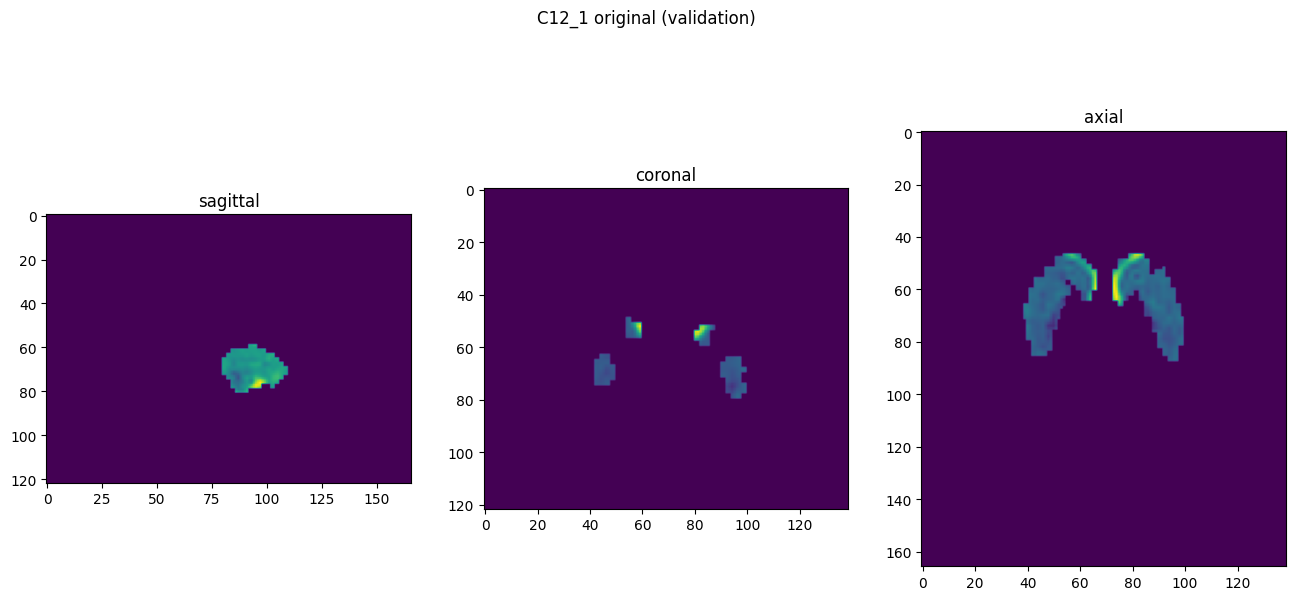

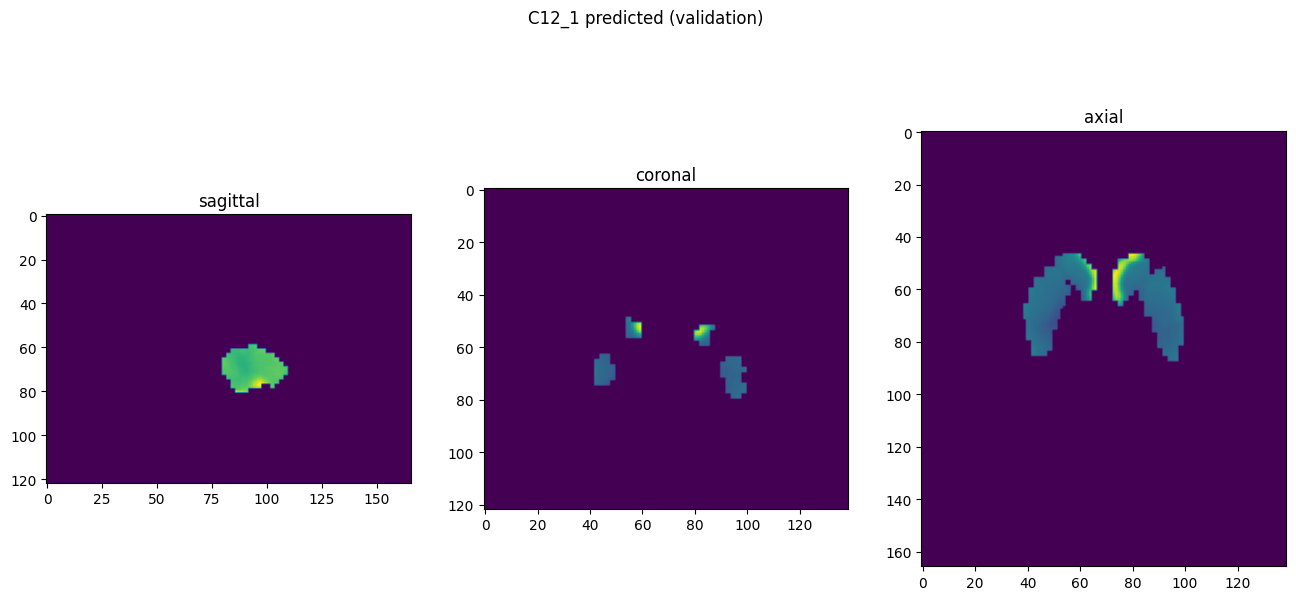

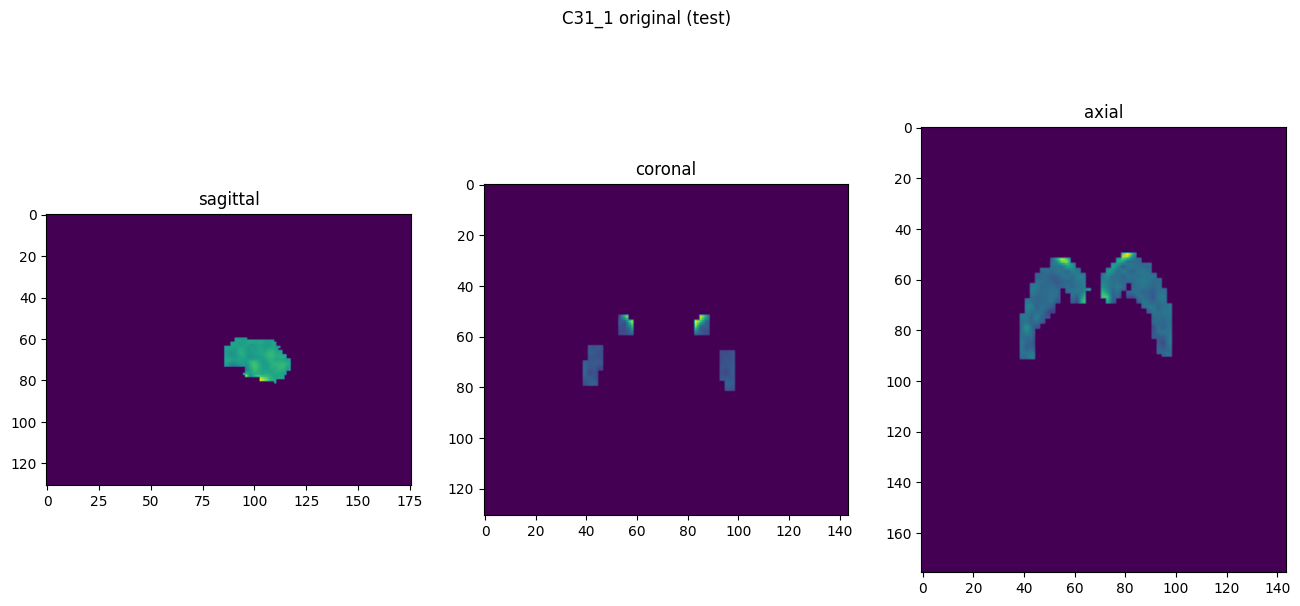

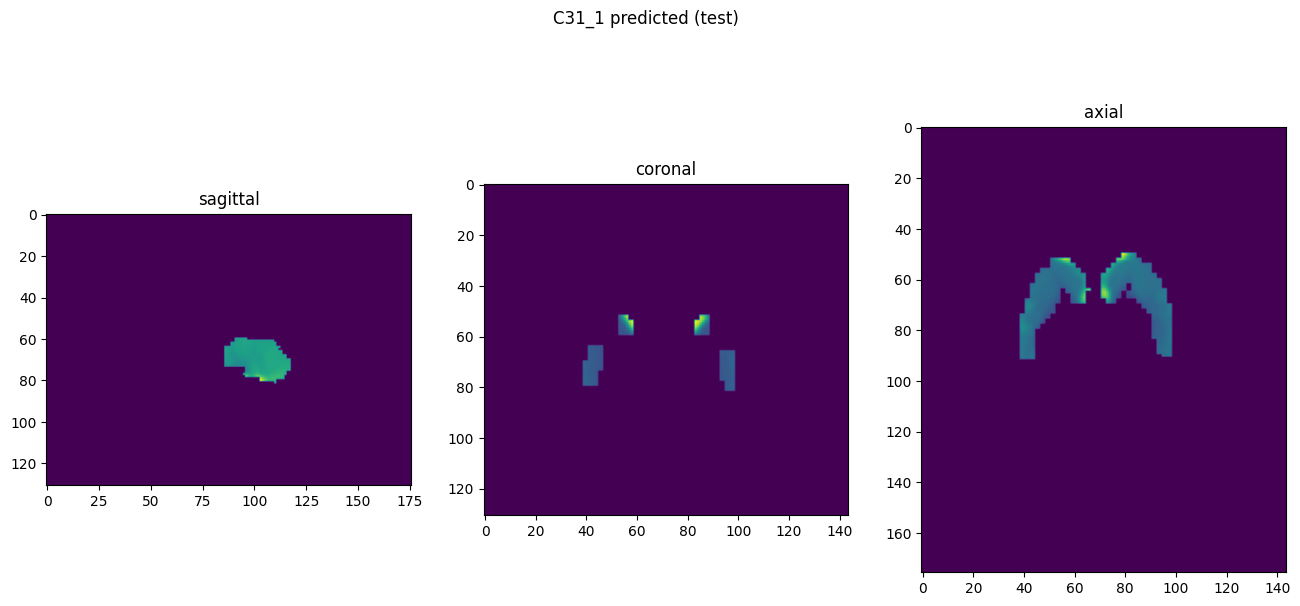

In [10]:
showResults(model, gen, threshold=None, background=False)